<a href="https://colab.research.google.com/github/rmkenv/newsletter/blob/main/newsletter7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3018650147.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time = pd.date_range('2024-04-01', periods=len(hours), freq='H')


Mean Absolute Error: 7.11 W per hour


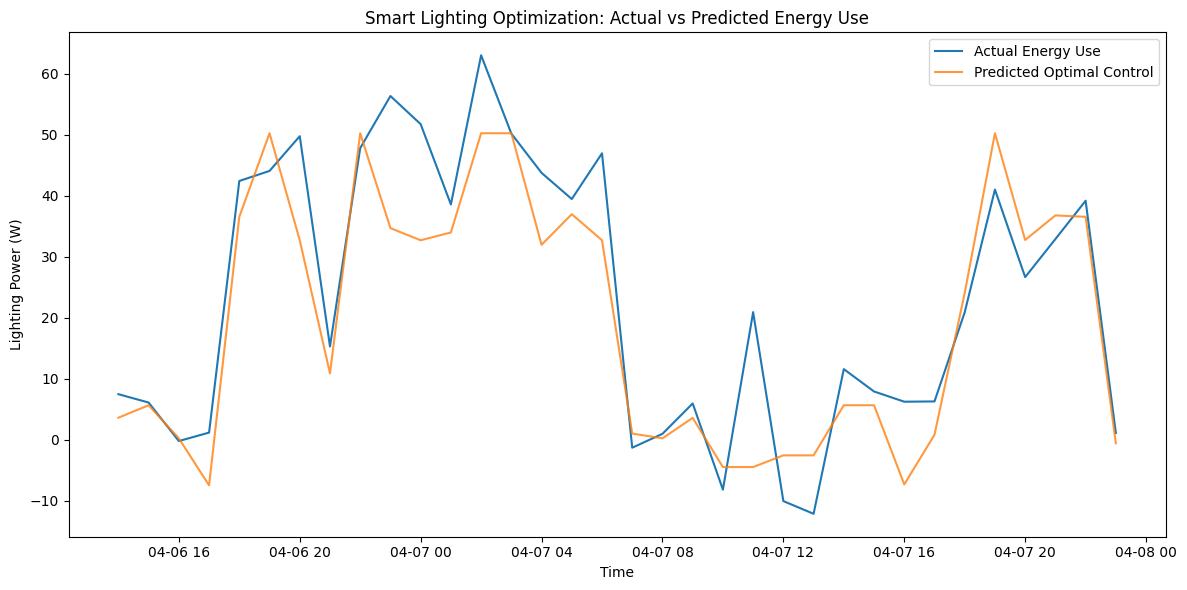

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Synthetic dataset: one week of hourly data
np.random.seed(42)
hours = np.arange(0, 24*7)
time = pd.date_range('2024-04-01', periods=len(hours), freq='H')

# Simulate daylight (lux) with diurnal cycle and noise
daylight = np.maximum(0, 8000 * np.sin((hours % 24 - 6) * np.pi / 12)) + np.random.normal(0, 500, len(hours))
daylight = np.clip(daylight, 0, None)

# Binary occupancy with weekday work hours
occupancy = ((time.hour >= 8) & (time.hour < 18)).astype(int)
weekend = (time.dayofweek >= 5).astype(int)
occupancy *= (1 - weekend)

# Target illuminance (lux)
target_lux = np.where(occupancy == 1, 500, 50)

# Simplified energy model reflecting daylight offset
energy_baseline = np.maximum(0, target_lux - daylight / 20)
energy_baseline = np.clip(energy_baseline, 0, 500)

df = pd.DataFrame({
    'datetime': time,
    'daylight': daylight,
    'occupancy': occupancy,
    'target_lux': target_lux,
    'energy_use': energy_baseline + np.random.normal(0, 10, len(hours))
})

# Train a regressor to predict control power given inputs
features = ['daylight', 'occupancy']
split = int(0.8 * len(df))
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(df[features][:split], df['energy_use'][:split])
pred = rf.predict(df[features][split:])

mae = mean_absolute_error(df['energy_use'][split:], pred)
print(f"Mean Absolute Error: {mae:.2f} W per hour")

plt.figure(figsize=(12, 6))
plt.plot(df['datetime'][split:], df['energy_use'][split:], label="Actual Energy Use", linewidth=1.5)
plt.plot(df['datetime'][split:], pred, label="Predicted Optimal Control", alpha=0.8)
plt.title("Smart Lighting Optimization: Actual vs Predicted Energy Use")
plt.ylabel("Lighting Power (W)")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()